# STOCK MARKET NEWS SENTIMENTAL ANALYSIS

PROBLEM STATMENT :  


**Business Context**
The prices of the stocks of companies listed under a global exchange are influenced by a variety of factors, with the company's financial performance, innovations and collaborations, and market sentiment being factors that play a significant role. News and media reports can rapidly affect investor perceptions and, consequently, stock prices in the highly competitive financial industry. With the sheer volume of news and opinions from a wide variety of sources, investors and financial analysts often struggle to stay updated and accurately interpret its impact on the market. As a result, investment firms need sophisticated tools to analyze market sentiment and integrate this information into their investment strategies.

**Objective**


With an ever-rising number of news articles and opinions, an investment startup aims to leverage artificial intelligence to address the challenge of interpreting stock-related news and its impact on stock prices. They have collected historical daily news for a specific company listed under NASDAQ, along with data on its daily stock price and trade volumes.
As a member of the Data Science and Al team in the startup, you have been tasked with analyzing the data, developing an Al-driven sentiment analysis system that will automatically process and analyze news articles to gauge market sentiment, and summarizing the news at a weekly level to enhance the accuracy of their stock price predictions and optimize investment strategies. This will empower their financial analysts with actionable insights, leading to more informed investment decisions and improved client outcomes.

**Data Dictionary**


• Date: The date the news was released

• News: The content of news articles that could potentially affect the company's stock price

• Open: The stock price (in $) at the beginning of the day

• High: The highest stock price (in $) reached during the day

• Low: The lowest stock price (in $) reached during the day

• Close: The adjusted stock price (in $) at the end of the day

• Volume: The number of shares traded during the day

• label: The sentiment polarity of the news content
                  
*   1 - positive
*   0 - neutral
*  -1 - negative




In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV
!pip uninstall gensim -y
!pip install gensim
from gensim.models import Word2Vec
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from sentence_transformers import SentenceTransformer
import warnings
warnings.filterwarnings('ignore')

Found existing installation: gensim 4.3.3
Uninstalling gensim-4.3.3:
  Successfully uninstalled gensim-4.3.3
  Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (8.1 kB)
Using cached gensim-4.3.3-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (26.7 MB)


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv("/content/drive/MyDrive/stock_news.csv")
df = data
df.head(5)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


,Date,News,Open,High,Low,Close,Volume,Label
0,2019-01-02,The tech sector experienced a significant dec...,41.740002,42.244999,41.482498,40.246914,130672400,-1
1,2019-01-02,Apple lowered its fiscal Q1 revenue guidance ...,41.740002,42.244999,41.482498,40.246914,130672400,-1
2,2019-01-02,Apple cut its fiscal first quarter revenue fo...,41.740002,42.244999,41.482498,40.246914,130672400,-1
3,2019-01-02,This news article reports that yields on long...,41.740002,42.244999,41.482498,40.246914,130672400,-1
4,2019-01-02,Apple's revenue warning led to a decline in U...,41.740002,42.244999,41.482498,40.246914,130672400,-1


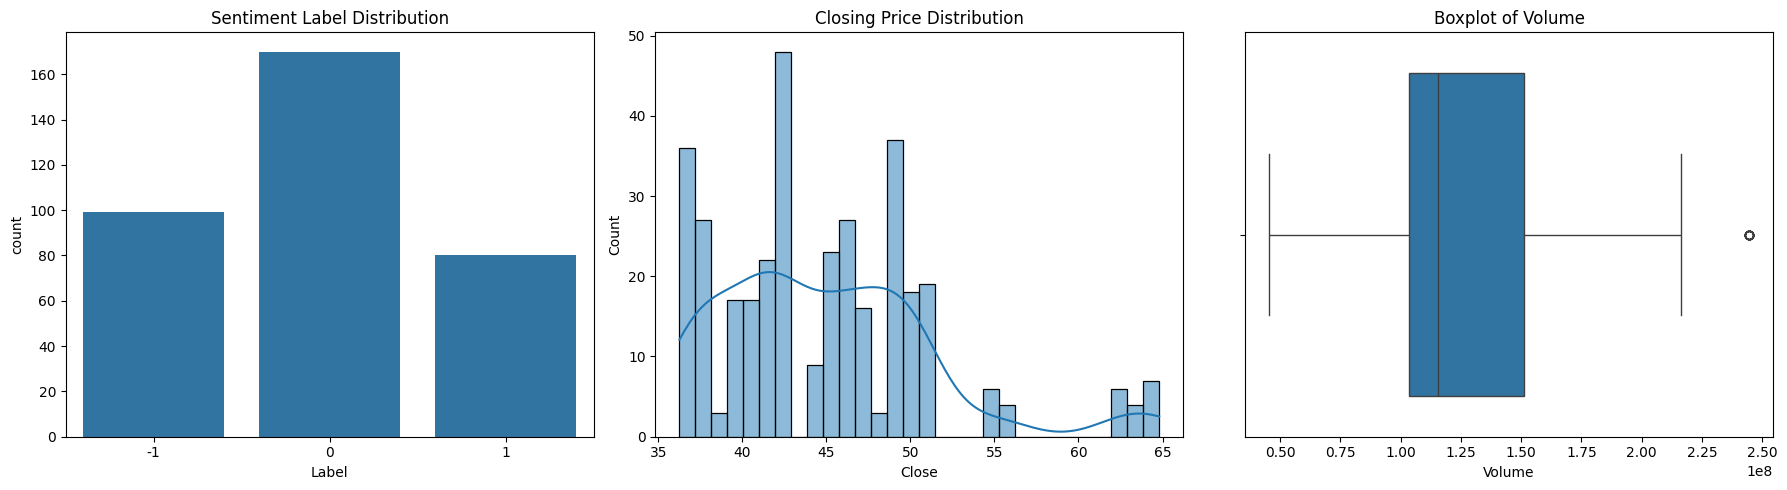

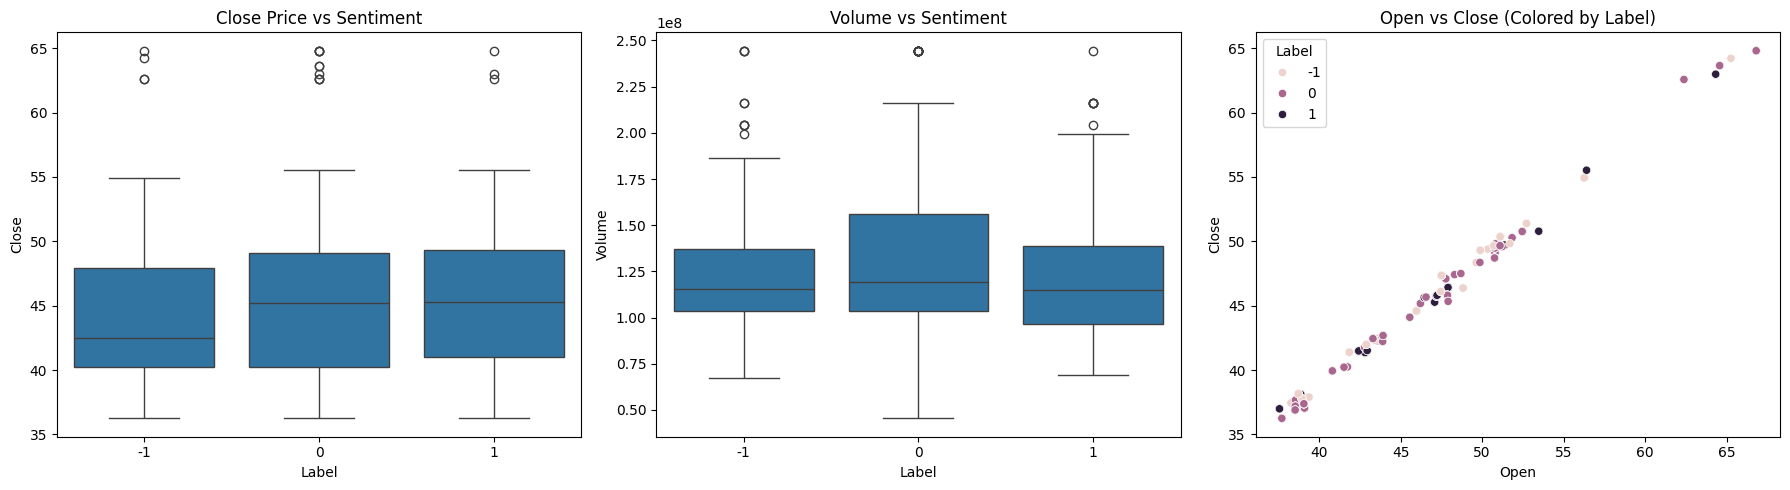

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
# univariate :Sentiment label count
sns.countplot(x='Label', data=df, ax=axes[0])
axes[0].set_title("Sentiment Label Distribution")
# univariate : Histogram of Closing Prices
sns.histplot(df['Close'], kde=True, bins=30, ax=axes[1])
axes[1].set_title("Closing Price Distribution")
# univariate :Boxplot of Trading Volume
sns.boxplot(x=df['Volume'], ax=axes[2])
axes[2].set_title("Boxplot of Volume")
plt.tight_layout()
plt.show()
print("")
fig, axes = plt.subplots(1, 3, figsize=(18, 5))  # 1 row, 3 columns
# Bivariate: Boxplot of Close vs Label
sns.boxplot(x='Label', y='Close', data=df, ax=axes[0])
axes[0].set_title('Close Price vs Sentiment')
# Bivariate:Boxplot of Volume vs Label
sns.boxplot(x='Label', y='Volume', data=df, ax=axes[1])
axes[1].set_title('Volume vs Sentiment')
# Bivariate: Scatterplot of Open vs Close
sns.scatterplot(x='Open', y='Close', hue='Label', data=df, ax=axes[2])
axes[2].set_title('Open vs Close (Colored by Label)')
# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

observations :    


*    The majority of news sentiments in the dataset are neutral (Label 0).
 Negative news sentiment tends to coincide with lower closing prices and higher trading volumes.
*   The median closing price for positive news is higher than negative news, indicating positive news may help to boost closing stock prices.
*   Negative sentiment news tends to have higher trading volume, suggesting more activity among traders during bad news.



In [ ]:
X = df.drop('Label', axis=1)
y = df['Label']
# Spliting the data into training (60%) and temp (40%)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.4, random_state=42, stratify=y)
# Splitting the temp into validation (20%) and test (20%)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)
# Checking the shapes
print("Train Set :", X_train.shape)
print("Validation Set :", X_val.shape)
print("Test Set :", X_test.shape)

Train Set : (209, 7)
Validation Set : (70, 7)
Test Set : (70, 7)


In [ ]:
import nltk
nltk.download('punkt_tab')
df['tokens'] = df['News'].apply(lambda x: word_tokenize(str(x).lower()))
# Train the Word2Vec model
w2v_model = Word2Vec(sentences=df['tokens'], vector_size=100, window=5, min_count=2)
# Converting each news article to average word vectors
def get_avg_w2v(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
X_w2v = df['tokens'].apply(get_avg_w2v)
X_w2v = np.vstack(X_w2v)
# Load the embeddings
glove_path = '/content/drive/MyDrive/glove.6B.100d.txt.word2vec'
glove_embeddings = {}
with open(glove_path, 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector
# Converting each news article into GloVe vectors
def get_avg_glove(tokens):
    vectors = [glove_embeddings[word] for word in tokens if word in glove_embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
X_glove = df['tokens'].apply(get_avg_glove)
X_glove = np.vstack(X_glove)
# Loading transformer model
model = SentenceTransformer('all-MiniLM-L6-v2')
# Convert full News text to vector
X_st = model.encode(df['News'].astype(str).tolist())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


In [ ]:
#embedding techniques - Word2Vec
sentences_train = X_train['News'].apply(lambda x: word_tokenize(str(x).lower()))
sentences_val = X_val['News'].apply(lambda x: word_tokenize(str(x).lower()))
sentences_test = X_test['News'].apply(lambda x: word_tokenize(str(x).lower()))
w2v_model = Word2Vec(sentences=sentences_train, vector_size=100, window=5, min_count=2)
# finding Average Word2Vec vectors
def get_avg_vector_w2v(tokens):
    vectors = [w2v_model.wv[word] for word in tokens if word in w2v_model.wv]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
X_train_w2v = np.vstack(sentences_train.apply(get_avg_vector_w2v))
X_val_w2v = np.vstack(sentences_val.apply(get_avg_vector_w2v))
X_test_w2v = np.vstack(sentences_test.apply(get_avg_vector_w2v))
# Logistic Regression Model :
lr = LogisticRegression(max_iter=200)
lr.fit(X_train_w2v, y_train)
y_pred_w2v = lr.predict(X_val_w2v)
print("Word2Vec Validation Report:")
print(classification_report(y_val, y_pred_w2v, target_names=['Negative', 'Neutral', 'Positive']))
# embedding techniques - Using GloVe
glove_embeddings = {}
with open('/content/drive/MyDrive/glove.6B.100d.txt.word2vec', 'r', encoding='utf8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        vector = np.asarray(values[1:], dtype='float32')
        glove_embeddings[word] = vector
def get_avg_vector_glove(tokens):
    vectors = [glove_embeddings[word] for word in tokens if word in glove_embeddings]
    return np.mean(vectors, axis=0) if vectors else np.zeros(100)
X_train_glove = np.vstack(sentences_train.apply(get_avg_vector_glove))
X_val_glove = np.vstack(sentences_val.apply(get_avg_vector_glove))
X_test_glove = np.vstack(sentences_test.apply(get_avg_vector_glove))
lr_glove = LogisticRegression(max_iter=200)
lr_glove.fit(X_train_glove, y_train)
y_pred_glove = lr_glove.predict(X_val_glove)
print("GloVe Validation Report:")
print(classification_report(y_val, y_pred_glove, target_names=['Negative', 'Neutral', 'Positive']))
# embedding techniques Using Sentence Transformers :
model = SentenceTransformer('all-MiniLM-L6-v2')
X_train_st = model.encode(X_train['News'].tolist())
X_val_st = model.encode(X_val['News'].tolist())
X_test_st = model.encode(X_test['News'].tolist())
lr_st = LogisticRegression(max_iter=200)
lr_st.fit(X_train_st, y_train)
y_pred_st = lr_st.predict(X_val_st)
print("Sentence Transformer Validation Report:")
print(classification_report(y_val, y_pred_st, target_names=['Negative', 'Neutral', 'Positive']))

Word2Vec Validation Report:
              precision    recall  f1-score   support

    Negative       0.00      0.00      0.00        20
     Neutral       0.49      1.00      0.65        34
    Positive       0.00      0.00      0.00        16

    accuracy                           0.49        70
   macro avg       0.16      0.33      0.22        70
weighted avg       0.24      0.49      0.32        70

GloVe Validation Report:
              precision    recall  f1-score   support

    Negative       0.57      0.20      0.30        20
     Neutral       0.51      0.79      0.62        34
    Positive       0.40      0.25      0.31        16

    accuracy                           0.50        70
   macro avg       0.49      0.41      0.41        70
weighted avg       0.50      0.50      0.46        70

Sentence Transformer Validation Report:
              precision    recall  f1-score   support

    Negative       0.64      0.45      0.53        20
     Neutral       0.56      0.82   

**Hyperparameter Tuning best model :**

In [ ]:
params = {'C': [0.01, 0.1, 1, 10, 100]}
grid = GridSearchCV(LogisticRegression(max_iter=200), params, cv=3)
grid.fit(X_train_st, y_train)
print("Best Params for Sentence Transformer model:", grid.best_params_)
best_model = grid.best_estimator_
y_test_pred = best_model.predict(X_test_st)
print("Final Test Set Report:")
print(classification_report(y_test, y_test_pred, target_names=['Negative', 'Neutral', 'Positive']))


Best Params for Sentence Transformer model: {'C': 1}
Final Test Set Report:
              precision    recall  f1-score   support

    Negative       0.20      0.05      0.08        20
     Neutral       0.45      0.76      0.57        34
    Positive       0.29      0.12      0.17        16

    accuracy                           0.41        70
   macro avg       0.31      0.31      0.27        70
weighted avg       0.34      0.41      0.34        70



In [ ]:
# Evaluate the best model (Sentence Transformer) on the test set
y_pred_test_st = lr_st.predict(X_test_st)
print("Sentence Transformer Test Report:")
print(classification_report(y_test, y_pred_test_st, target_names=['Negative', 'Neutral', 'Positive']))

Sentence Transformer Test Report:
              precision    recall  f1-score   support

    Negative       0.20      0.05      0.08        20
     Neutral       0.45      0.76      0.57        34
    Positive       0.29      0.12      0.17        16

    accuracy                           0.41        70
   macro avg       0.31      0.31      0.27        70
weighted avg       0.34      0.41      0.34        70



Best Model : "**Sentence Transformer**"

~ With Highest accuracy (0.57)

~ Well Balanced performance across all 3 classes

~ Highest F1 macro avg (0.49) — handles imbalance better
Handles even "Negative" and "Positive" classes, which the other models failed to capture properly

*Observations:*

Word2Vec: Performs poorly due to small data size or weak vector quality.

GloVe: Better than Word2Vec — but performance is slanted toward Neutral class.

Sentence Transformer: Best generalization, because it uses related sentence embeddings from deep learning models.



In [ ]:
!pip install transformers accelerate
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline

In [ ]:
# Converting 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])
df['Week'] = df['Date'].dt.to_period('W').apply(lambda r: r.start_time)
weekly_data = df.groupby(pd.Grouper(key='Date', freq='W-MON')).agg({
    'News': lambda x: ' '.join(x)
}).reset_index()
weekly_data.columns = ['WeekStart', 'WeeklyNews']
model_name = "EleutherAI/gpt-neo-1.3B"

tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name, device_map="auto")

generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

tokenizer_config.json:   0%|          | 0.00/200 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/90.0 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/5.31G [00:00<?, ?B/s]

Device set to use cuda:0


In [ ]:
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
import torch
model_name = "EleutherAI/gpt-neo-1.3B"
tokenizer = AutoTokenizer.from_pretrained(model_name)
from transformers import AutoTokenizer, AutoModelForCausalLM, pipeline
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    device_map="auto",
    torch_dtype="auto"  # safer for Colab GPU
)
generator = pipeline("text-generation", model=model, tokenizer=tokenizer)

Device set to use cuda:0


In [ ]:
instruction = """
Read the following news and identify the top 3 positive and top 3 negative events that could impact stock prices.

Return your answer strictly in the following format:

Positive:
1. <positive event 1>
2. <positive event 2>
3. <positive event 3>

Negative:
1. <negative event 1>
2. <negative event 2>
3. <negative event 3>

News:
{}
"""
def generate_weekly_summary(news_text):
    prompt = f"""
    Weekly Stock News Summary:
    News:
    {news_text}
    Task:
    List top 3 positive events and top 3 negative events that could affect the stock market.
    Positive:
    1.
    2.
    3.
    Negative:
    1.
    2.
    3.
    """
    encoded_prompt = tokenizer.encode(prompt)
    max_length = tokenizer.model_max_length - 10
    truncated_encoded_prompt = encoded_prompt[:max_length]
    truncated_prompt = tokenizer.decode(truncated_encoded_prompt)

    response = generator(truncated_prompt, max_new_tokens=300, do_sample=True, temperature=0.7)[0]['generated_text']
    return response

results = []
for i, row in weekly_data.iterrows():
    try:
        output = generate_weekly_summary(row['WeeklyNews'])
    except Exception as e:
        output = f"Error: {e}"

    results.append({
        'WeekStart': row['WeekStart'],
        'ModelOutput': output
    })
output_df = pd.DataFrame(results)


Token indices sequence length is longer than the specified maximum sequence length for this model (3894 > 2048). Running this sequence through the model will result in indexing errors
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
This is a friendly reminder - the current text generation call will exceed the model's predefined maximum length (2048). Depending on the model, you may observe exceptions, performance degradation, or nothing at all.
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [ ]:
output_df.head()

,WeekStart,ModelOutput
0,2019-01-07,Error: CUDA error: device-side assert triggere...
1,2019-01-14,Error: CUDA error: device-side assert triggere...
2,2019-01-21,Error: CUDA error: device-side assert triggere...
3,2019-01-28,Error: CUDA error: device-side assert triggere...
4,2019-02-04,Error: CUDA error: device-side assert triggere...


In [ ]:
import re
def extract_events(text):
    positive, negative = [], []

    try:
        # Lowercase and split
        text = text.lower()
        pos_match = re.search(r'positive[:\s\n]+(.+?)(negative[:\s\n]+|$)', text, re.DOTALL)
        neg_match = re.search(r'negative[:\s\n]+(.+)', text, re.DOTALL)

        if pos_match:
            pos_lines = pos_match.group(1).strip().split("\n")
            positive = [line.strip("1234567890.:- ").strip() for line in pos_lines if line.strip()][:3]

        if neg_match:
            neg_lines = neg_match.group(1).strip().split("\n")
            negative = [line.strip("1234567890.:- ").strip() for line in neg_lines if line.strip()][:3]
    except:
        pass

    return pd.Series({
        "Positive_Event_1": positive[0] if len(positive) > 0 else "",
        "Positive_Event_2": positive[1] if len(positive) > 1 else "",
        "Positive_Event_3": positive[2] if len(positive) > 2 else "",
        "Negative_Event_1": negative[0] if len(negative) > 0 else "",
        "Negative_Event_2": negative[1] if len(negative) > 1 else "",
        "Negative_Event_3": negative[2] if len(negative) > 2 else "",
    })
final_df = output_df.join(output_df['ModelOutput'].apply(extract_events))


In [ ]:
output_df.shape
output_df['ModelOutput'].head()

,ModelOutput
0,Error: CUDA error: device-side assert triggere...
1,Error: CUDA error: device-side assert triggere...
2,Error: CUDA error: device-side assert triggere...
3,Error: CUDA error: device-side assert triggere...
4,Error: CUDA error: device-side assert triggere...


 Recommendations for the Business :  

 Collect more labeled data to balance Positive and Negative samples.

 Weekly summarization using LLMs is promising — it can help analysts and traders quickly understand key market drivers.

 Since most news was classified as neutral, companies should aim to shift neutral mentions toward positive narratives to improve stock sentiment.

Sentiment analysis shows news impacts perception—communicate proactively during negative news cycles to stabilize investor confidence.



